This Notebook demonstrates the two user interfaces of the `zappend` tool, namely the CLI and API.

## Prepare test data

In [1]:
import math
import os
import os.path
import shutil

import numpy as np
import pyproj
import xarray as xr

First let's define a utility to remove non-empty directories:

In [2]:
def rmdir(path: str):
    if os.path.exists(path):
        shutil.rmtree(path)

The following function is used to generate a slice dataset for testing. 
Its dimensions are `time`, `y`, `x`. The dataset structure is quite common 
in Earth remote sensing. 

In [3]:
def make_slice_dataset(img_size: tuple[int, int] = (720, 360),
                       doy: int = 0) -> xr.Dataset:
    """Prepare a time slice dataset.
    
    Args:
        img_size: Spatial image size in pixels
        doy: Day of the year
    """
    
    w, h = img_size
    
    dx = dy = 360.0 / w
    x_data = np.linspace(-180+dx/2, 180-dx/2, w, dtype="float64")
    y_data = np.linspace(-90+dy/2, 90-dy/2, h, dtype="float64")
    x = xr.DataArray(x_data, dims="x")
    y = xr.DataArray(y_data, dims="y")

    dtime = np.timedelta64(24, 'h')
    time_data = np.arange(
        np.datetime64('2023-01-01') + (doy + 0.5) * dtime,
        np.datetime64('2023-01-01') + (doy + 1.5) * dtime,
        dtime,
        dtype='datetime64'
    )
    time = xr.DataArray(time_data, dims="time")
    
    crs = xr.DataArray(np.array(0), 
                       attrs=pyproj.CRS("EPSG:4326").to_cf())
    
    chl_data = np.full((1, h, w), 10 + 4 * math.sin(doy/2 + 0.1), dtype="float64")
    chl = xr.DataArray(chl_data,
                       dims=("time", "y", "x"),
                       attrs={"long_name": "Chlorophyll Concentration", 
                              "units": "mg/m^3"})
                       
    tsm_data = np.full((1, h, w), 5 + 2 * math.sin(doy/3 + 0.2), dtype="float64")                           
    tsm = xr.DataArray(tsm_data, 
                       dims=("time", "y", "x"),
                       attrs={"long_name": "Total Suspended Matter", 
                              "units": "mg/m^3"})                     
    
    return xr.Dataset(
        data_vars={"chl": chl, "tsm": tsm, "crs": crs},
        coords={"time": time, "y": y, "x": x}
    )

This is how a single slice looks like.

In [4]:
make_slice_dataset(doy=140)

<xarray.Dataset>
Dimensions:  (time: 1, y: 360, x: 720)
Coordinates:
  * time     (time) datetime64[ns] 2023-05-21T12:00:00
  * y        (y) float64 -89.75 -89.25 -88.75 -88.25 ... 88.25 88.75 89.25 89.75
  * x        (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.2 178.8 179.2 179.8
Data variables:
    chl      (time, y, x) float64 13.33 13.33 13.33 13.33 ... 13.33 13.33 13.33
    tsm      (time, y, x) float64 5.509 5.509 5.509 5.509 ... 5.509 5.509 5.509
    crs      int32 0

Let's create `N` of such slice datasets as input for the `zappend` tool.

In [5]:
N = 10

In [6]:
test_data_dir = "testdata"

rmdir(test_data_dir)
os.mkdir(test_data_dir)

slice_paths = []
for doy in range(N):
    slice_path = f"{test_data_dir}/slice-{doy:04d}.zarr"
    slice_paths.append(slice_path)
    slice_ds = make_slice_dataset(doy=doy)
    slice_ds.to_zarr(slice_path)

Path to the target dataset to be created:

In [7]:
target_path = f"{test_data_dir}/target.zarr"

## zappend CLI

In [8]:
!zappend --help

Usage: zappend [OPTIONS] [SLICES]...

  Create or update a Zarr datacube TARGET from slice datasets SLICES.

Options:
  -c, --config CONFIG    Configuration JSON or YAML file. If multiple are
                         passed, subsequent configurations are incremental to
                         the previous ones.
  -t, --target TARGET    Target Zarr dataset path or URI. Overrides the
                         'target_dir' configuration field.
  --dry-run              Run the tool without creating, changing, or deleting
                         any files.
  --help-config json|md  Show configuration help and exit.
  --help                 Show this message and exit.


Run the tool without any configuration:

In [9]:
!zappend -t {target_path} {" ".join(slice_paths)}

Check the target dataset just generated:

In [10]:
target_ds = xr.open_zarr(target_path)
target_ds

<xarray.Dataset>
Dimensions:  (time: 10, y: 360, x: 720)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-01-10T12:00:00
  * x        (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.2 178.8 179.2 179.8
  * y        (y) float64 -89.75 -89.25 -88.75 -88.25 ... 88.25 88.75 89.25 89.75
Data variables:
    chl      (time, y, x) float64 dask.array<chunksize=(1, 90, 360), meta=np.ndarray>
    crs      int32 ...
    tsm      (time, y, x) float64 dask.array<chunksize=(1, 90, 360), meta=np.ndarray>

Check that time is monotonically increasing:

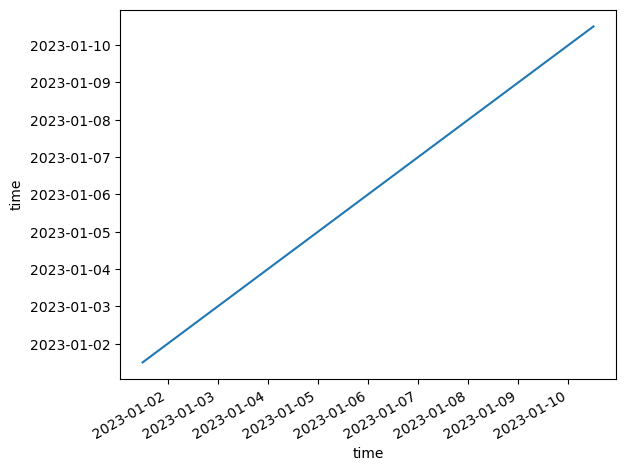

In [11]:
target_ds.time.plot()

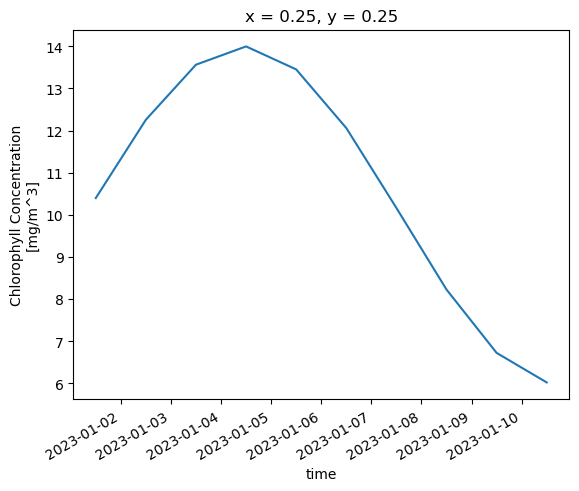

In [12]:
target_ds.chl.sel(x=0, y=0, method="nearest").plot()

Now we'll add some configuration. 
You can run `zappend --help-config md` to get configuration help, or do that programmatically:

In [13]:
from IPython.display import Markdown
from zappend.config import get_config_schema

In [14]:
Markdown(get_config_schema(format="md"))

## Configuration for the `zappend` tool


### `version`

Configuration schema version. Allows the schema to evolve while still preserving backwards compatibility.
Its value is `1`.

### `target_dir`

Type _string_.
The URI or local path of the target Zarr dataset. Must be a directory.

### `target_storage_options`

Type _object_.
Options for the filesystem given by the URI of `target_dir`.

### `slice_engine`

Type _string_.
The name of the engine to be used for opening contributing datasets. Refer to the `engine` argument of the function `xarray.open_dataset()`.

### `slice_storage_options`

Type _object_.
Options for the filesystem given by the protocol of the URIs of contributing datasets.

### `slice_polling`

Defines how to poll for contributing datasets.
Must be one of the following:
* No polling, fail immediately if dataset is not available.
  Its value is `false`.
* Poll using default values.
  Its value is `true`.
* Type _object_.
  Polling parameters.
  The keys `interval`, `timeout` are required.
  
  * `interval`:
    Type _number_.
    Polling interval in seconds.
    Defaults to `2`.
  * `timeout`:
    Type _number_.
    Polling timeout in seconds.
    Defaults to `60`.
  

### `temp_dir`

Type _string_.
The URI or local path of the directory that will be used to temporarily store rollback information.

### `temp_storage_options`

Type _object_.
Options for the filesystem given by the protocol of `temp_dir`.

### `zarr_version`

The Zarr version to be used.
Its value is `2`.

### `fixed_dims`

Type _object_.
Specifies the fixed dimensions of the target dataset. Keys are dimension names, values are dimension sizes.

The object's values are of type _integer_.

### `append_dim`

Type _string_.
The name of the variadic append dimension.
Defaults to `"time"`.

### `variables`

Type _object_.
Defines dimensions, encoding, and attributes for variables in the target dataset. Object property names refer to variable names. The special name `*` refers to all variables, which is useful for defining common values.

The object's values are of type _object_.
Variable metadata.

* `dims`:
  Type _array_.
  The names of the variable's dimensions in the given order. Each dimension must exist in contributing datasets.
  
  The array's items are of type _string_.
* `encoding`:
  Type _object_.
  Variable storage encoding. Settings given here overwrite the encoding settings of the first contributing dataset.
  
  * `dtype`:
    Storage data type
    Must be one of `"int8", "uint8", "int16", "uint16", "int32", "uint32", "int64", "uint64", "float32", "float64"`.
  * `chunks`:
    Storage chunking.
    Must be one of the following:
    * Type _array_.
      Chunk sizes in the order of the dimensions.
      
      The array's items are of type _integer_.
    * Disable chunking.
      Its value is `null`.
  * `fill_value`:
    Storage fill value.
    Must be one of the following:
    * Type _number_.
      A number of type and unit of the given storage `dtype`.
    * Not-a-number. Can be used only if storage `dtype` is `float32` or `float64`.
      Its value is `"NaN"`.
    * No fill value.
      Its value is `null`.
  * `scale_factor`:
    Type _number_.
    Scale factor for computing the in-memory value: `memory_value = scale_factor * storage_value + add_offset`.
  * `add_offset`:
    Type _number_.
    Add offset for computing the in-memory value: `memory_value = scale_factor * storage_value + add_offset`.
  * `units`:
    Type _string_.
    Units of the storage data type if memory data type is date/time.
  * `calendar`:
    Type _string_.
    The calendar to be used if memory data type is date/time.
  * `compressor`:
    Type _array_ | _null_.
    Compressor definition. Set to `null` to disable data compression.
    The key `id` is required.
    
    * `id`:
      Type _string_.
    
  * `filters`:
    Type _array_ | _null_.
    Filters. Set to `null` to not use filters.
    
    The array's items are of type _object_.
    Filter definition.
    The key `id` is required.
    
    * `id`:
      Type _string_.
    
  
* `attrs`:
  Type _object_.
  Arbitrary variable metadata attributes.


### `included_variables`

Type _array_.
Specifies the names of variables to be included in the target dataset. Defaults to all variables found in the first contributing dataset.

The array's items are of type _string_.

### `excluded_variables`

Type _array_.
Specifies the names of individual variables to be excluded  from all contributing datasets.

The array's items are of type _string_.

### `persist_mem_slices`

Type _boolean_.
Persist in-memory slices and reopen from a temporary Zarr before appending them to the target dataset. This can prevent expensive re-computation of dask chunks at the cost of additional i/o.
Defaults to `false`.

### `disable_rollback`

Type _boolean_.
Disable rolling back dataset changes on failure. Effectively disables transactional dataset modifications, so use this setting with care.
Defaults to `false`.

### `dry_run`

Type _boolean_.
If 'true', log only what would have been done, but don't apply any changes.
Defaults to `false`.

### `logging`

Type _object_.
Logging configuration. For details refer to the [dictionary schema](https://docs.python.org/3/library/logging.config.html#logging-config-dictschema) of the Python module `logging.config`.
The key `version` is required.

* `version`:
  Logging schema version.
  Its value is `1`.
* `formatters`:
  Type _object_.
  Formatter definitions. Each key is a formatter id and each value is an object describing how to configure the corresponding formatter.
  
  The object's values are of type _object_.
  Formatter configuration.
  
  * `format`:
    Type _string_.
    Format string in the given `style`.
    Defaults to `"%(message)s"`.
  * `datefmt`:
    Type _string_.
    Format string in the given `style` for the date/time portion.
    Defaults to `"%Y-%m-%d %H:%M:%S,uuu"`.
  * `style`:
    Determines how the format string will be merged with its data.
    Must be one of `"%", "{", "$"`.
  
* `filters`:
  Type _object_.
  Filter definitions. Each key is a filter id and each value is a dict describing how to configure the corresponding filter.
  
  The object's values are of type _object_.
  Filter configuration.
* `handlers`:
  Type _object_.
  Handler definitions. Each key is a handler id and each value is an object describing how to configure the corresponding handler.
  
  The object's values are of type _object_.
  Handler configuration. All keys other than the following are passed through as keyword arguments to the handler's constructor.
  The key `class` is required.
  
  * `class`:
    Type _string_.
    The fully qualified name of the handler class. See [logging handlers](https://docs.python.org/3/library/logging.handlers.html).
  * `level`:
    The level of the handler.
    Must be one of `"CRITICAL", "ERROR", "WARNING", "INFO", "DEBUG", "NOTSET"`.
  * `formatter `:
    Type _string_.
    The id of the formatter for this handler.
  * `filters`:
    Type _array_.
    A list of ids of the filters for this logger.
    
    The array's items are of type _string_.
  
* `loggers`:
  Type _object_.
  Logger definitions. Each key is a logger name and each value is an object describing how to configure the corresponding logger. The tool's logger has the id `'zappend'`.
  
  The object's values are of type _object_.
  Logger configuration.
  
  * `level`:
    The level of the logger.
    Must be one of `"CRITICAL", "ERROR", "WARNING", "INFO", "DEBUG", "NOTSET"`.
  * `propagate `:
    Type _boolean_.
    The propagation setting of the logger.
  * `filters`:
    Type _array_.
    A list of ids of the filters for this logger.
    
    The array's items are of type _string_.
  * `handlers`:
    Type _array_.
    A list of ids of the handlers for this logger.
    
    The array's items are of type _string_.
  



In [15]:
config = {
    "target_dir": target_path, 
    "variables": {
        # We want the time coordinate variable to use a larger chunk size
        # than the default (= 1 here)
        "time": {
            "encoding": {
                "chunks": [100]
            }
        }
    },
    # Log to the console.
    # Note you could also configure the log output for dask here.
    "logging": {
        "version": 1,
        "formatters": {
            "normal": {
                "format": "%(asctime)s %(levelname)s %(message)s",
                "style": "%"
            }
        },
        "handlers": {
            "console": {
                "class": "logging.StreamHandler",
                "formatter": "normal"
            }
        },
        "loggers": {
            "zappend": {
                "level": "INFO",
                "handlers": ["console"]
            }
        }
    }
}

In [16]:
config_path = f"{test_data_dir}/zappend-config.yaml"

In [17]:
import yaml
with open(config_path, mode="w") as f:
    yaml.dump(config, f)

In [18]:
rmdir(target_path)

In [19]:
!zappend -c {config_path} {" ".join(slice_paths)}

2024-01-15 14:45:29,755 INFO Opening slice dataset from testdata/slice-0000.zarr
2024-01-15 14:45:29,765 INFO Creating target dataset testdata/target.zarr
2024-01-15 14:45:30,032 INFO Transaction completed.
2024-01-15 14:45:30,032 INFO Slice dataset testdata/slice-0000.zarr closed
2024-01-15 14:45:30,037 INFO Opening slice dataset from testdata/slice-0001.zarr
2024-01-15 14:45:30,043 INFO Updating target dataset testdata/target.zarr
2024-01-15 14:45:30,090 INFO Transaction completed.
2024-01-15 14:45:30,090 INFO Slice dataset testdata/slice-0001.zarr closed
2024-01-15 14:45:30,095 INFO Opening slice dataset from testdata/slice-0002.zarr
2024-01-15 14:45:30,101 INFO Updating target dataset testdata/target.zarr
2024-01-15 14:45:30,148 INFO Transaction completed.
2024-01-15 14:45:30,148 INFO Slice dataset testdata/slice-0002.zarr closed
2024-01-15 14:45:30,153 INFO Opening slice dataset from testdata/slice-0003.zarr
2024-01-15 14:45:30,159 INFO Updating target dataset testdata/target.zarr

In [20]:
rmdir(target_path)

## zappend API

In [21]:
from zappend.api import zappend

The `zappend` function can process slice paths or URIs, e.g., `s3://...` or slice datasets of type `xr.Dataset`:

In [22]:
zappend(slice_paths, config=config)

2024-01-15 14:45:30,863 INFO Opening slice dataset from testdata/slice-0000.zarr
2024-01-15 14:45:30,872 INFO Creating target dataset testdata/target.zarr
2024-01-15 14:45:30,913 INFO Transaction completed.
2024-01-15 14:45:30,913 INFO Slice dataset testdata/slice-0000.zarr closed
2024-01-15 14:45:30,919 INFO Opening slice dataset from testdata/slice-0001.zarr
2024-01-15 14:45:30,927 INFO Updating target dataset testdata/target.zarr
2024-01-15 14:45:30,984 INFO Transaction completed.
2024-01-15 14:45:30,984 INFO Slice dataset testdata/slice-0001.zarr closed
2024-01-15 14:45:30,990 INFO Opening slice dataset from testdata/slice-0002.zarr
2024-01-15 14:45:30,996 INFO Updating target dataset testdata/target.zarr
2024-01-15 14:45:31,048 INFO Transaction completed.
2024-01-15 14:45:31,048 INFO Slice dataset testdata/slice-0002.zarr closed
2024-01-15 14:45:31,054 INFO Opening slice dataset from testdata/slice-0003.zarr
2024-01-15 14:45:31,061 INFO Updating target dataset testdata/target.zarr

In [23]:
target_ds = xr.open_zarr("testdata/target.zarr")
target_ds

<xarray.Dataset>
Dimensions:  (time: 10, y: 360, x: 720)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-01-10T12:00:00
  * x        (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.2 178.8 179.2 179.8
  * y        (y) float64 -89.75 -89.25 -88.75 -88.25 ... 88.25 88.75 89.25 89.75
Data variables:
    chl      (time, y, x) float64 dask.array<chunksize=(1, 90, 360), meta=np.ndarray>
    crs      int32 ...
    tsm      (time, y, x) float64 dask.array<chunksize=(1, 90, 360), meta=np.ndarray>

In [24]:
rmdir(target_path)

The `zappend` function can also process in-memory slice datasets of type `xr.Dataset`:

In [25]:
slice_generator = (xr.open_zarr(slice_path) for slice_path in slice_paths)

In [26]:
zappend(slice_generator, config=config)

2024-01-15 14:45:31,617 INFO Processing in-memory slice dataset #0
2024-01-15 14:45:31,619 INFO Creating target dataset testdata/target.zarr
2024-01-15 14:45:31,656 INFO Transaction completed.
2024-01-15 14:45:31,658 INFO Slice dataset #0 processed
2024-01-15 14:45:31,669 INFO Processing in-memory slice dataset #1
2024-01-15 14:45:31,671 INFO Updating target dataset testdata/target.zarr
2024-01-15 14:45:31,721 INFO Transaction completed.
2024-01-15 14:45:31,721 INFO Slice dataset #1 processed
2024-01-15 14:45:31,731 INFO Processing in-memory slice dataset #2
2024-01-15 14:45:31,733 INFO Updating target dataset testdata/target.zarr
2024-01-15 14:45:31,784 INFO Transaction completed.
2024-01-15 14:45:31,785 INFO Slice dataset #2 processed
2024-01-15 14:45:31,795 INFO Processing in-memory slice dataset #3
2024-01-15 14:45:31,796 INFO Updating target dataset testdata/target.zarr
2024-01-15 14:45:31,848 INFO Transaction completed.
2024-01-15 14:45:31,848 INFO Slice dataset #3 processed
2024

In [27]:
target_ds = xr.open_zarr("testdata/target.zarr")
target_ds

<xarray.Dataset>
Dimensions:  (time: 10, y: 360, x: 720)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-01-10T12:00:00
  * x        (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.2 178.8 179.2 179.8
  * y        (y) float64 -89.75 -89.25 -88.75 -88.25 ... 88.25 88.75 89.25 89.75
Data variables:
    chl      (time, y, x) float64 dask.array<chunksize=(1, 90, 360), meta=np.ndarray>
    crs      int32 ...
    tsm      (time, y, x) float64 dask.array<chunksize=(1, 90, 360), meta=np.ndarray>

In [28]:
target_ds.time.encoding

{'chunks': (100,),
 'preferred_chunks': {'time': 100},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'days since 2023-01-01T12:00:00',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('int64')}

In [29]:
target_ds.chl.encoding

{'chunks': (1, 90, 360),
 'preferred_chunks': {'time': 1, 'y': 90, 'x': 360},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float64')}

In [30]:
rmdir(test_data_dir)